In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_12_attn_learning_rates'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
# sample_data = sample_data[sample_data['class'] != 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 654333,  (dropped rows: 9263859)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
5


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [16]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [17]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [18]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 1351])

### More balanced sample

In [19]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [20]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      11741
Name: class, dtype: int64

In [21]:
balanced_data_sample_row()

sentence_id                                               576240
token_id                                                      10
class                                                      PLAIN
before                                                         -
after                                                         to
class_org                                                  PLAIN
a_word_ind                                               [57, 0]
sentence       " results of the parliamentary by elections he...
Name: 503393, dtype: object

### Samples

In [22]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence'].split(' ')
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

LETTERS : PSV's -> p s v's <EOS> [24, 17, 177, 0]
['in', '2002', ',', 'takak', 'was', 'picked', 'for', '<SAMPLE>', 'first', 'team', '.']
torch.Size([1, 6, 104])


In [23]:
%%timeit
get_random_sample()

144 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [24]:
use_cuda = True

In [25]:
MAX_ATTENTION_LENGTH = 30

In [28]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
# tmp[~tmp['before'].str.contains('/')].sample(2)

746

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
132078,151992,1,ELECTRONIC,http://www.pressreference.com/Be-Co/China.html...,h t t p colon slash slash w w w dot p r e s s ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...",see <SAMPLE> netherlands media network .
100607,115633,2,ELECTRONIC,http://www.nasa.gov/audience/forstudents/5-8/f...,h t t p colon slash slash w w w dot n a s a do...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...",nasa explores <SAMPLE> .


### Encoder

In [67]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.GRU(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = hidden_words.view(1, -1)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = hidden_chars.view(1, -1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        #for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
        #    hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)

        all_outputs_chars_padded = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        att_length = min(len(all_outputs_chars[0]), MAX_ATTENTION_LENGTH-1)
        all_outputs_chars_padded[0:att_length] = all_outputs_chars[0][0:att_length]
        
        output = torch.cat((output_words, output_chars), 1)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, all_outputs_chars_padded

    def init_hidden(self):
        var1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1 = var1.cuda(); var2 = var2.cuda()
        return (var1, var2)
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=512,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn

EncoderRNN (
  (rnn_words): GRU(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): GRU(104, 256, batch_first=True, bidirectional=True)
)

In [68]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    #s_bef, s_aft, s_class, s_sentence = get_random_sample(True)
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(tmp_encoder_output, tmp_encoder_outputs), tmp = test_encoder_single_sample()
tmp
tmp_encoder_output.size()
tmp_encoder_outputs.size()

TRT


'TRT'

torch.Size([1, 640])

torch.Size([30, 512])

### Decoder

In [69]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, chars_encoded_size,
                 n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(self.hidden_size+self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size+chars_encoded_size, self.hidden_size)
        
        #self.module_attn = torch.nn.ModuleList([self.emb_lin, self.dropout, self.attn, self.attn_combine])
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
        #self.module_rnn = torch.nn.ModuleList([self.rnn, self.lin_out])

    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = embedded[0]
                
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        #return embedded, attn_applied
        
        rnn_input = torch.cat((embedded, attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden[0], attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        
    def mods_split(self):
        mods = list(decoder_rnn.modules())[1:]
        for gru_index, mod in enumerate(mods):
            #print(mod)
            if type(mod) == torch.nn.modules.rnn.GRU:
                break
        return mods[:gru_index], mods[gru_index:]
        
    def mods_attn(self):
        return self.mods_split()[0]
        
    def mods_gru(self):
        return self.mods_split()[1]

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=tmp_encoder_output.size()[1],
                         chars_encoded_size=tmp_encoder_outputs.size()[1], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_encoder_output, tmp_encoder_outputs)
#tmp
[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (1351 -> 640)
  (dropout): Dropout (p = 0.1)
  (attn): Linear (1280 -> 30)
  (attn_combine): Linear (1152 -> 640)
  (rnn): GRU(640, 640, batch_first=True)
  (lin_out): Linear (640 -> 1351)
)

[torch.Size([1, 1351]), torch.Size([1, 640]), torch.Size([1, 30])]

In [59]:
tmp = [{'params': mod.parameters(), 'lr': 3} for mod in decoder_rnn.mods_attn()]
tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
tmp.append(
    {'params': encoder_rnn.parameters()}
)
tmp

[{'lr': 3, 'params': <generator object Module.parameters at 0x7efbdd183570>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7efbdd183ba0>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7efbdd183b48>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7efbdd183780>},
 {'params': <generator object Module.parameters at 0x7efbdd1832b0>},
 {'params': <generator object Module.parameters at 0x7efbdd1830a0>},
 {'params': <generator object Module.parameters at 0x7efbdd183518>}]

# Training etc

### Accuracy

In [70]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    decoder_input = Variable(sos_tensor).cuda()
    decoder_hidden = encoder_output
    
    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('localized localized polymerization politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize',
 'localized localized polymerization politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize politicize',
 'november eighteenth two thousand six',
 ('November 18, 2006',
  [69, 94, 5, 8, 20, 0],
  'NUMBERS',
  ['the',
   'contest',
   'on',
   '<SAMPLE>',
   'marked',
   'the',
   'first',
   'time',
   'ever',
   'these',
   'teams',
   'had',
   'been',
   'ranked',
   'no']))

In [61]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

&              => nines rumors rumors rumors rumors square square square square square square square square square square square square square square square || [55, 0] 
                  ['minnesota', 'atlas', '<SAMPLE>', 'gazetteer', '.']
December 10, 2009 => twelve twelve twelve rumors rumors square square square square square square square square square square square square square square square || [65, 93, 5, 8, 15, 0] 
                  ['retrieved', '<SAMPLE>', '.']


In [42]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.16 s, sys: 24 ms, total: 2.19 s
Wall time: 2.18 s


0.0

### Training

In [259]:
def train(s_bef, s_aft, s_sentence, optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda() 
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    target_arr = s_aft
    optimizer.zero_grad()
    loss = 0
    
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    
    decoder_hidden = encoder_output
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()
    
    # not used yet
    # https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    if clip_parameters_value:
        for m in [decoder_rnn, encoder_rnn]:
            torch.nn.utils.clip_grad_norm(m.parameters(), clip_parameters_value)

    optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [215]:
tmp = [op for op in decoder_rnn.parameters()]

In [251]:
tmp[0].min()

Variable containing:
-1.0848
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [211]:
[len(op['params']) for op in optimizer.param_groups]

[2, 0, 2, 2, 4, 2, 16]

In [208]:
1+1

2

In [72]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):
    global optimizer
    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    tmp = [{'params': mod.parameters(), 'lr': (lr/10)} for mod in decoder_rnn.mods_attn()]
    tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
    tmp.append(
        {'params': encoder_rnn.parameters()}
    )
    optimizer = torch.optim.Adam(tmp, lr=lr)
    
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             optimizer=optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [73]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_12_attn_learning_rates


In [74]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   7.004   |   7.18: sr -> localized nineteen (✗: senior) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.06% (       6/   10000)
    18  36% (  0m 35s)   7.071   |   7.10: & -> <EOS> (✗: and) (forcing)
    27  54% (  0m 35s)   6.686   |   6.97: - -> <EOS> (✗: to) (forcing)
    36  72% (  0m 36s)   6.341   |   6.92: & -> <EOS> (✗: and) (forcing)
    45  90% (  0m 36s)   6.307   |   3.59: W. ->  (✗: w) 


In [75]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 6s)   3.086   |   4.16: BioLib.cz -> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: b i o l i b dot c z) (forcing)


In [77]:
optimizer.param_groups[0]['lr']
optimizer.param_groups[6]['lr']

1e-05

0.0001

In [78]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 17s)   2.717   |   4.70: April 27, 2014 -> nineteen twenty a t e o (✗: april twenty seventh twenty fourteen) 
  3000  22% (  0m 31s)   2.439   |   1.64: USC -> m (✗: u s c) 
  4000  33% (  0m 46s)   2.177   |   2.90: IVF -> u s (✗: i v f) 
  5000  44% (   1m 2s)   2.120   |   2.67: kilometres -> theater (✗: kilometers) (forcing)
  6000  56% (  1m 19s)   2.001   |   1.53: $91,504 -> nineteen thousand (✗: ninety one thousand five hundred four dollars) 
  7000  67% (  1m 34s)   1.952   |   0.01: & -> and (✓) 
  8000  78% (  1m 52s)   1.810   |   2.78: K. A. -> s s (✗: k a) 
  9000  89% (   2m 9s)   1.768   |   1.89: 50 -> one (✗: fifty) (forcing)
 10000 100% (  2m 28s)   1.683   |   1.45: _ -> number (✗: underscore) (forcing)


In [95]:
time.sleep(60*60*3)

In [96]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  2m 44s)   0.767   |   0.99: 511 -> five hundred one (✗: five hundred eleven) 
 30000  22% (  5m 35s)   0.397   |   0.00: 1997 -> nineteen ninety seven (✓) 
 40000  33% (  8m 18s)   0.327   |   0.01: 1981 -> nineteen eighty one (✓) 
 50000  44% ( 11m 13s)   0.273   |   2.60: http://rise.cayey.upr.edu/main/) -> h t t p colon colon slash s e s i i h i s slash slash slash com r slash slash s r e r s e s s e e i e s i n e e e s s s e e e e i n i (✗: h t t p colon slash slash r i s e dot c a y e y dot u p r dot e d u slash m a i n slash c l o s i n g p a r e n t h e s i s) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/50000_(EncoderRNN/DecoderRNN)
Accuracy: 88.57% (    8857/   10000)
 60000  56% ( 14m 59s)   0.230   |   0.04: 2000 -> two thousand (✓) (forcing)
 70000  67% ( 17m 52s)   0.209   |   0.01: Nov -> november (✓) 
 80000  78% ( 20m 44s)   0.253   |   0.62: workhouses.org.uk -> w o r k h o u s e s dot o r g dot u k k (✗: w o r k h o u s e s dot 

In [97]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000   5% (  2m 52s)   0.203   |   2.66: 3,431 -> thirty thirty three hundred thirty thirty thirty (✗: three thousand four hundred thirty one) (forcing)
120000  10% (  5m 44s)   0.271   |   0.15: Ets -> e t's (✓) 
130000  15% (  8m 38s)   0.229   |   0.00: vol -> volume (✓) (forcing)
140000  20% ( 11m 36s)   0.214   |   0.00: CAHPERD -> c a h p e r d (✓) (forcing)
150000  25% ( 14m 27s)   0.191   |   0.01: 44 -> forty four (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/150000_(EncoderRNN/DecoderRNN)
Accuracy: 92.67% (    9267/   10000)
160000  30% (  18m 9s)   0.270   |   0.01: .52 -> point five two (✓) 
170000  35% (  21m 2s)   0.222   |   0.01: # -> number (✓) 
180000  40% ( 23m 54s)   0.273   |   0.00: UK -> u k (✓) (forcing)
190000  45% ( 26m 47s)   0.203   |   0.00: jr -> junior (✓) (forcing)
200000  50% ( 29m 38s)   0.264   |   0.00: ltd -> limited (✓) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/200000_(EncoderRNN/DecoderRNN)
Accuracy

In [98]:
print_local_wrong_predictions()

051452-        => one one one one five one one five one sil one sil one sil one sil one sil one sil || [25, 14, 9, 19, 14, 5, 0] 
                  ['5', 'penguin', 'guide', 'to', 'jazz', 'on', 'cd', ',', 'fifth', 'edition', ',', 'penguin', 'books', ',', 'london', ',', '2000', ',', 'isbn', '0', '-', '14', '-', '<SAMPLE>', 'x', ',', 'p', '.', '620', '.']
Occupyatlanta.org => o c c u p a y u m a u n u m a u n u y u || [25, 21, 21, 43, 24, 86, 22, 30, 42, 22, 29, 30, 22, 74, 25, 35, 53, 0] 
                  ['<SAMPLE>', '(', 'official', 'website', ')', '.']
01             => one one        || [25, 9, 0] 
                  ['airay', 'was', 'born', 'at', 'clifton', 'in', 'westmoreland', 'in', '1600', '/', '<SAMPLE>', '.']
WCFT-          => w c f r        || [52, 21, 37, 30, 0] 
                  ['<SAMPLE>', 'fm', "'s", 'main', 'studio', 'is', 'located', 'at', '4', '50', 'route', '2', 'oh', '4', ',', 'highway', 'in', 'selinsgrove', '.']
12.1 mph       => twelve point two one || [47, 46, 9,

In [99]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

310000   5% (  2m 55s)   0.424   |   0.00: UK -> u k (✓) 
320000  10% (  5m 51s)   0.310   |   0.02: 20 km -> twenty kilometers (✓) 
330000  15% (  8m 45s)   0.394   |   0.00: vs -> versus (✓) 
340000  20% ( 11m 32s)   0.377   |   0.00: coloured -> colored (✓) (forcing)
350000  25% ( 14m 16s)   0.421   |   0.00: 58 -> fifty eight (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/350000_(EncoderRNN/DecoderRNN)
Accuracy: 85.33% (    8533/   10000)
360000  30% ( 17m 53s)   0.562   |   0.01: 10 -> ten (✓) (forcing)
370000  35% ( 20m 46s)   0.427   |   0.00: - -> to (✓) 
380000  40% ( 23m 33s)   0.442   |   0.00: # -> number (✓) 
390000  45% ( 26m 20s)   0.477   |   0.15: Osy -> o s y (✓) 
400000  50% (  29m 9s)   0.488   |   0.00: 1983 -> nineteen eighty three (✓) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/400000_(EncoderRNN/DecoderRNN)
Accuracy: 84.11% (    8411/   10000)
410000  55% ( 32m 54s)   0.357   |   0.12: January 3, 1921 -> january third 

In [100]:
print_local_wrong_predictions()

50             => fifty percent  || [38, 0] 
                  ['if', 'the', 'tapes', 'need', 'permanent', 'preservation', ',', 'they', 'should', 'be', 'stored', 'at', '46', '-', '<SAMPLE>', 'degrees', 'fahrenheit', 'at', '20', '-', '30%', 'relative', 'humidity', '.']
cuxhaven.de    => c u x dot o e dot dot o r m e r m || [21, 43, 97, 45, 22, 54, 28, 29, 74, 26, 28, 0] 
                  ['marie', 'louise', 'rendant', ':', 'kugelbake', ',', 'alte', 'liebe', '&', 'der', 'steubenhoft', '(', 'regionenverlag', 'gmbh', ')', 'isbn', '978', '-', '3', '-', '940389', '-', '35', '-', '0', '(', 'german', ')', 'die', 'kugelbake', 'at', '<SAMPLE>', '(', 'german', ')', 'retrieved', '29', '-', 'feb', '-', '2012', '.']
mij            => m              || [32, 31, 60, 0] 
                  ['"', 'een', 'tweede', 'plaats', 'telt', 'niet', 'voor', '<SAMPLE>', '"', '.']
Ngobe          => n g o b o o    || [29, 53, 25, 36, 28, 0] 
                  ['noncomala', 'was', 'the', 'main', 'and', 'creative', 'de

In [101]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

510000  10% (  2m 49s)   0.291   |   2.65: 15:36 -> fifteen thirty thirty six (✗: fifteen thirty six) 
520000  20% (  5m 42s)   0.256   |   0.05: 2011 -> twenty eleven (✓) (forcing)
530000  30% (  8m 41s)   0.301   |   0.10: VO -> v o (✓) 
540000  40% ( 11m 33s)   0.270   |   9.70: 11-21-2010 -> the eleventh of november twenty ten (✗: november twenty first twenty ten) 
550000  50% ( 14m 21s)   0.270   |   0.00: - -> to (✓) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/550000_(EncoderRNN/DecoderRNN)
Accuracy: 89.26% (    8926/   10000)
560000  60% (  18m 6s)   0.310   |   0.01: CZ -> c z (✓) (forcing)
570000  70% ( 20m 56s)   0.262   |   0.15: II -> the second (✓) (forcing)
580000  80% ( 23m 46s)   0.263   |   0.00: & -> and (✓) 
590000  90% ( 26m 43s)   0.263   |   0.00: 18 -> eighteen (✓) 
600000 100% ( 29m 35s)   0.207   |   0.00: _ -> underscore (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/600000_(EncoderRNN/DecoderRNN)
Accuracy: 89.11% ( 

In [102]:
print_local_wrong_predictions()

HamptonRoads.com => h a m p a t h o n o n d o m || [45, 22, 32, 24, 30, 25, 29, 35, 25, 22, 26, 17, 74, 21, 25, 32, 0] 
                  ['<SAMPLE>', '(', 'the', 'virginian', 'pilot', ')', '.']
worldcat.org   => w o r l d c a a dot o r g || [52, 25, 35, 42, 26, 21, 22, 30, 74, 25, 35, 53, 0] 
                  ['"', 'regionalism', 'and', 'ethnic', 'nationalism', 'in', 'france', ':', 'a', 'case', 'study', 'of', 'corsica', '"', ',', '<SAMPLE>', ';', 'accessed', '1', 'march', '2014', '.']
1994 won       => one hundred ninety four hundred ninety four || [9, 8, 15, 10, 23, 19, 381, 0] 
                  ['partizan', '<SAMPLE>', '2', ':', '0', '.']
http://www.firstworldwar.com/bio/navarre.htm => h t p colon slash slash w w w w w w w w w dot c a h o || [45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74, 37, 31, 35, 17, 30, 52, 25, 35, 42, 26, 52, 22, 35, 74, 156, 101, 36, 31, 25, 101, 29, 22, 54, 22, 35, 35, 28, 74, 45, 30, 32, 0] 
                  ['firstworldwar', '.', 'com', 'website', 'page

In [103]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

610000  10% (  2m 47s)   0.485   |   0.69: ZK- -> z hundred (✗: z k) 
620000  20% (  5m 34s)   0.529   |   0.00: centre -> center (✓) 
630000  30% (  8m 26s)   0.445   |   0.02: February 19, 1953 -> february nineteenth nineteen fifty three (✓) 
640000  40% ( 11m 15s)   0.473   |   0.00: & -> and (✓) 
650000  50% (  14m 3s)   0.407   |   0.00: 6 -> six (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/650000_(EncoderRNN/DecoderRNN)
Accuracy: 84.51% (    8451/   10000)
660000  60% ( 17m 47s)   0.447   |   0.09: November 5, 2009 -> november fifth two thousand nine (✓) 
670000  70% ( 20m 39s)   0.481   |   0.00: J. -> j (✓) 
680000  80% ( 23m 25s)   0.454   |   0.59: 3702 -> three thousand seven hundred two o (✗: three thousand seven hundred two) 
690000  90% ( 26m 13s)   0.509   |   0.56: 1000 -> one o (✗: one thousand) 
700000 100% (  29m 2s)   0.471   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/700000_(EncoderRNN/DecoderRNN)
Accurac

In [104]:
print_local_wrong_predictions()

1800           => eighteen o     || [40, 10, 0] 
                  ['the', 'british', 'recaptured', 'her', 'in', '<SAMPLE>', ',', 'returned', 'her', 'to', 'service', ',', 'but', 'sold', 'her', 'in', '1801', '.']
79.8           => seventy point nine eight || [33, 15, 46, 16, 0] 
                  ['for', 'every', '100', 'females', 'age', '18', 'and', 'over', ',', 'there', 'were', '<SAMPLE>', 'males', '.']
Download.com   => d o w n n dot o m dot c dot o m || [26, 25, 52, 29, 42, 25, 22, 26, 74, 21, 25, 32, 0] 
                  ['"', '<SAMPLE>', 'wraps', 'downloads', 'in', 'bloatware', ',', 'lies', 'about', 'motivations', '"', '.']
III            => two            || [13, 0] 
                  ['22', ':', 'st', 'mary', 'magdalene', 'penitent', ',', '<SAMPLE>', 'class', '.']
SANDF          => s a n d f f    || [17, 22, 29, 26, 37, 0] 
                  ['col', 'l', 'b', 'van', 'stade', ',', 'senior', 'staff', 'officer', 'rationalisation', ',', '<SAMPLE>', '(', '1997', ')', '.']
Climatepre

In [105]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

710000   5% (  2m 51s)   0.424   |   0.00: 42 -> forty two (✓) 
720000  10% (  5m 37s)   0.313   |   0.01: N. -> n (✓) 
730000  15% (  8m 28s)   0.450   |   0.00: ISBN -> i s b n (✓) 
740000  20% ( 11m 25s)   0.397   |   0.02: IAAF -> i a a f (✓) 
750000  25% ( 14m 13s)   0.314   |   0.00: dr -> doctor (✓) (forcing)
Saved model to data/models/whole_gen_12_attn_learning_rates/750000_(EncoderRNN/DecoderRNN)
Accuracy: 85.66% (    8566/   10000)
760000  30% ( 17m 53s)   0.467   |   0.00: U.S. -> u s (✓) 
770000  35% ( 20m 54s)   0.349   |   0.00: M. -> m (✓) 
780000  40% ( 23m 50s)   0.346   |   0.00: favourite -> favorite (✓) 
790000  45% ( 26m 42s)   0.413   |   0.00: & -> and (✓) 
800000  50% ( 29m 33s)   0.383   |   0.00: LLC -> l l c (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/800000_(EncoderRNN/DecoderRNN)
Accuracy: 85.08% (    8508/   10000)
810000  55% ( 33m 16s)   0.398   |   0.00: 1996 -> nineteen ninety six (✓) 
820000  60% (  36m 3s)   0.354   |   0.00: st 

In [106]:
print_local_wrong_predictions()

4:29:10        => ten o ten      || [19, 245, 6, 15, 215, 55, 44, 182, 0] 
                  ['yusuke', 'mamada', '(', 'jpn', ')', '<SAMPLE>', 'women', "'s", 'half', 'marathon', '1', '.']
6.6/km²        => six point six k || [20, 46, 20, 112, 106, 89, 0] 
                  ['there', 'were', '998', 'housing', 'units', 'at', 'an', 'average', 'density', 'of', '17', '.', '2', 'per', 'square', 'mile', '(', '<SAMPLE>', ')', '.']
SAT            => s a t          || [222, 0] 
                  ['in', '2006', '<SAMPLE>', 'had', '724', 'members', '.']
xstarsnews.com => x s t a r n e s e o c e o m o c o c o m || [97, 17, 30, 22, 35, 17, 29, 28, 52, 17, 74, 21, 25, 32, 0] 
                  ['"', 'winners', 'of', 'the', '2007', 'ficeb', 'ninfa', 'awards', '"', ',', 'h', '.', 'b', '.', ',', 'october', '10', ',', '2007', ',', '<SAMPLE>', '.']
qu'un          => u u            || [111, 43, 43, 29, 0] 
                  ['in', 'exile', ',', 'hugo', 'dedicated', 'it', 'to', 'his', 'home', 'country', ':'

In [107]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

910000   3% (  2m 49s)   0.349   |   0.00: & -> and (✓) 
920000   7% (  5m 43s)   0.357   |   0.03: Mbiwa -> m b i w a (✓) 
930000  10% (  8m 34s)   0.206   |   0.00: MLC -> m l c (✓) 
940000  13% ( 11m 26s)   0.279   |   0.00: & -> and (✓) 
950000  17% ( 14m 15s)   0.403   |   0.00: 1954 -> nineteen fifty four (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/950000_(EncoderRNN/DecoderRNN)
Accuracy: 88.46% (    8846/   10000)
960000  20% (  18m 1s)   0.252   |   4.20: Prologue -> p r (✗: prolog) 
970000  23% ( 20m 55s)   0.351   |   0.01: WGCH -> w g c h (✓) 
980000  27% ( 23m 46s)   0.302   |   0.00: & -> and (✓) 
990000  30% ( 26m 36s)   0.307   |   4.29: 1060s -> one hundred (✗: ten sixties) 
1000000  33% ( 29m 32s)   0.319   |   0.23: FLN -> n l n (✗: f l n) 
Saved model to data/models/whole_gen_12_attn_learning_rates/1000000_(EncoderRNN/DecoderRNN)
Accuracy: 88.66% (    8866/   10000)
1010000  37% ( 33m 18s)   0.301   |   2.77: DigitalSignageToday.com -> d g g a r 

In [108]:
print_local_wrong_predictions()

11             => eleven         || [9, 9, 0] 
                  ['rnx', '(', 'hox', '<SAMPLE>', 'l', '2', ',', 'tlx', '3', ')', 'belongs', 'to', 'a', 'family', 'of', 'orphan', 'homeobox', 'genes', 'that', 'encode', 'dna', '-', 'binding', 'nuclear', 'transcription', 'factors', '.']
recolonise     => recognize      || [891, 0] 
                  ['organisms', 'that', 'dislike', 'this', 'disturbance', 'are', 'replaced', 'by', 'others', 'better', 'able', 'to', 'rapidly', '<SAMPLE>', '"', 'clean', '"', 'sediment', '.']
Thecorporatecounsel.net => t e t t r t t t t t t t e t t t e t t t || [30, 45, 28, 21, 25, 35, 24, 25, 35, 22, 30, 28, 21, 25, 43, 29, 17, 28, 42, 74, 29, 28, 30, 0] 
                  ['<SAMPLE>', ',', 'accessed', 'march', '31', ',', '2011', 'vanderwerff', ',', 'todd', '(', 'may', '12', ',', '2014', ')', '.']
optimised      => o              || [689, 0] 
                  ['by', '2006', ',', 'the', 'emergency', 'services', 'in', 'the', 'tunnel', 'will', 'be', 'upgraded', ',

In [109]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1210000   3% (  2m 51s)   0.332   |   0.86: 22 October 1918 -> the twenty second of october nineteen twenty (✗: the twenty second of october nineteen eighteen) 
1220000   7% (  5m 41s)   0.361   |   0.00: & -> and (✓) 


IndexError: list index out of range

In [160]:
optimizer.param_groups[0]['lr']
optimizer.param_groups[6]['lr']

5e-05

0.0005

In [161]:
state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1150000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [162]:
print_local_wrong_predictions()

movies.nytimes.com => m o v e s h e s s i c o m || [32, 25, 54, 31, 28, 17, 74, 29, 86, 30, 31, 32, 28, 17, 74, 21, 25, 32, 0] 
                  ['new', 'york', 'times', 'overview', 'of', 'film', ',', '<SAMPLE>', ';', 'accessed', 'august', '10', ',', '2015', '.']
StatisticsPro-Football-Reference.com => o a t i s h s e s e s e s e s e s f s e || [17, 30, 22, 30, 31, 17, 30, 31, 21, 17, 24, 35, 25, 26, 22, 17, 45, 37, 25, 25, 30, 36, 22, 42, 42, 26, 22, 17, 45, 35, 28, 37, 28, 35, 28, 29, 21, 28, 74, 21, 25, 32, 0] 
                  ['pro', '-', 'football', '-', 'reference', '.', 'com', ':', '2012', 'nfl', 'standings', ',', 'team', '&', 'offensive', '<SAMPLE>', ':', '2012', 'nfl', 'opposition', '&', 'defensive', 'statisticsgeneral', 'referenceszimmer', ',', 'john', ';', 'marini', ',', 'matt', ',', 'eds', '.']
TRIUMF's       => t r i u m's f's department || [30, 35, 31, 43, 32, 239, 0] 
                  ['<SAMPLE>', 'nuclear', 'medicine', 'department', 'is', 'part', 'of', 'this', 'divi

In [164]:
train_iterations(n_iters=2000, print_every=1000, teacher_forcing_ratio=0.2, lr=0.0001)

1229334  50% (   1m 1s)   0.635   |   1.94: rootsweb.com -> r o o d s b d dot c o m (✗: r o o t s w e b dot c o m) 
1230334 100% (  1m 36s)   0.649   |   0.02: 1949 -> nineteen forty nine (✓) (forcing)


In [165]:
time.sleep(24*60*60)

In [166]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

1240334   5% (  5m 54s)   0.636   |   3.06: 4SeasonsOfAsthma.ca -> s p s f s i i s s s s s s s s s s s s s s s s (✗: f o u r s e a s o n s o f a s t h m a dot c a) 
Saved model to data/models/whole_gen_12_attn_learning_rates/1250000_(EncoderRNN/DecoderRNN)
Accuracy: 66.31% (    6631/   10000)
1250334  10% ( 12m 45s)   0.578   |   0.03: RIMPUFF -> r i m p u f f (✓) 
1260334  15% ( 17m 59s)   0.611   |   0.00: P. -> p (✓) (forcing)
1270334  20% (  23m 9s)   0.636   |   0.07: MOELCI -> m o e l c i (✓) 
1280334  25% ( 28m 11s)   0.569   |   0.00: J. -> j (✓) 
1290334  30% ( 33m 24s)   0.605   |   0.04: NORCECA -> n o r c e c a (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/1300000_(EncoderRNN/DecoderRNN)
Accuracy: 68.13% (    6813/   10000)
1300334  35% (  40m 8s)   0.552   |   1.85: SENSATIONSFILMS -> s e n s a i i s s s s s s o o (✗: s e n s a t i o n s f i l m s) (forcing)
1310334  40% ( 45m 26s)   0.553   |   0.00: - -> to (✓) 
1320334  45% ( 50m 38s)   0.654   |   2.

In [167]:
print_local_wrong_predictions()

2007-01-02     => the second of february two thousand seven || [11, 73, 12, 63, 5, 8, 18, 0] 
                  ['jackson', ',', 'mike', '(', '<SAMPLE>', ')', '.']
AVANTVIEW      => a v a n t v i i e || [22, 54, 22, 29, 30, 54, 31, 28, 52, 0] 
                  ['<SAMPLE>', 'solutions', 'limited', '—', 'www', '.', 'avantview', '.', 'com', '.']
DESTAPE        => d e s t a p    || [26, 28, 17, 30, 22, 24, 28, 0] 
                  ['"', 'technical', 'services', '<SAMPLE>', '—', 'mercer', 'county', '"', '(', 'pdf', ')', '.']
14V            => fourteen hundred || [50, 282, 0] 
                  ['the', 'prc', '350', 'had', 'its', 'own', '<SAMPLE>', '4', 'ah', 'nicad', 'and', 'a', 'battery', 'cassette', 'for', 'use', 'with', 'alkaline', 'or', 'dry', 'cells', '.']
BONVICINO      => six o n v i n i n i o || [36, 25, 29, 54, 31, 21, 31, 29, 25, 0] 
                  ['weksler', ',', 'marcelo', ';', 'cibele', 'r', '.', '<SAMPLE>', '(', '2007', ')', '.']
eurominiconferencegraz2013.wordpress.com 

In [168]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1440334   2% (  5m 15s)   0.622   |   0.00: 8 November 2010 -> the eighth of november twenty ten (✓) 
Saved model to data/models/whole_gen_12_attn_learning_rates/1450000_(EncoderRNN/DecoderRNN)
Accuracy: 70.06% (    7006/   10000)
1450334   4% ( 11m 47s)   0.609   |   0.65: www.laurenknowsbest.com -> w w w dot c o m (✗: w w w dot l a u r e n k n o w s b e s t dot c o m) 
1460334   6% (  17m 6s)   0.539   |   1.08: 21,455 -> twenty thousand thousand five hundred fifty five (✗: twenty one thousand four hundred fifty five) 
1470334   8% ( 22m 19s)   0.546   |   0.17: Here.com -> h e r e dot c o m (✓) 
1480334  10% ( 27m 29s)   0.503   |   2.64: http://www.uslsoccer.com/home/688866.html -> h t t p colon slash slash w w w w w w w slash slash w w w dot i o i i x w i i i x w i i i x w i i i x w i i i x w i o e i x w i o e x w i (✗: h t t p colon slash slash w w w dot u s l s o c c e r dot com slash h o m e slash s i x e i g h t e i g h t e i g h t s i x s i x dot h t m l) 
1490334  12% (  33m

IndexError: list index out of range

In [170]:
#state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1400000_'
state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1150000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))


In [176]:
# balanced_data = balanced_data_org
balanced_data_randomize = balanced_data_randomize_org
balanced_data_randomize()

In [177]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=10000)

Accuracy: 88.94% (    8894/   10000)


0.8894

In [178]:
state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1400000_'
#state_dict_path = 'data/models/whole_gen_12_attn_learning_rates/1150000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
balanced_data_randomize = balanced_data_randomize_org
balanced_data_randomize()

In [179]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=10000)

Accuracy: 88.79% (    8879/   10000)


0.8879

In [253]:
clip_parameters_value = 0.2

In [260]:
train_iterations(n_iters=100, print_every=50, teacher_forcing_ratio=0.2, lr=0.0001)

1498996  50% (   0m 4s)   0.405   |   0.00: & -> and (✓) 
1499046 100% (  0m 10s)   0.298   |   0.03: I.D. -> i d (✓) 


In [261]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=1000)

Accuracy: 88.80% (     888/    1000)


0.888

In [262]:
balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

In [263]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

Saved model to data/models/whole_gen_12_attn_learning_rates/1500000_(EncoderRNN/DecoderRNN)
Accuracy: 71.02% (    7102/   10000)
1509046   3% (  9m 42s)   0.488   |   0.01: 3 July 1942 -> the third of july nineteen forty two (✓) 


IndexError: list index out of range

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=400000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

### Show attention

In [ ]:
balanced_data.sample(5)

In [ ]:
balanced_data.groupby('class')['class'].count()
len(balanced_data)

In [127]:
def balanced_data_randomize_long():
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    
    bal_data = pd.concat([v.sample(min(2000, len(v))) for k, v in balanced_data_classes_select])
    long_data = sample_data[sample_data['before'].str.len()>8].sample(4000)
    elec_data = sample_data[sample_data['class']=='ELECTRONIC']
    let_long_data = sample_data[(sample_data['class'] == 'LETTERS') & (sample_data['before'].str.len() > 5)]
    balanced_data = pd.concat([bal_data, long_data, elec_data, let_long_data])#.drop_duplicates()
    balanced_data = balanced_data[~balanced_data.index.duplicated(keep='first')]
    
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.5
    balanced_data_accessed_counter = 0

balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

input:   March 30, 2009
output:  ['march', 'thirtieth', 'two', 'thousand', 'nine']
target:    march thirtieth two thousand nine


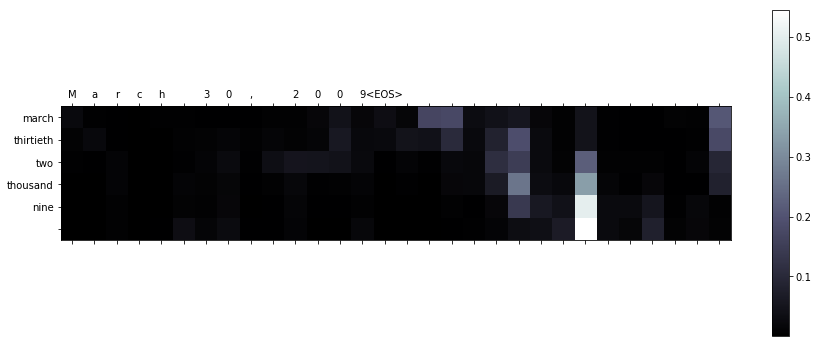

In [156]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    #inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    inp_arr = input_sentence
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    #sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence'].split(' ')

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [ ]:
balanced_data.groupby('class')['class'].unique()

In [ ]:
def test_in_categories(iter_len = 1000):
    wrong_preds = {}
    for cat in categories_all:
        tmp_data = sample_data[sample_data['class'] == cat].sample(iter_len)
        correct_n = 0
        wrong_preds_arr = []

        for _ in range(iter_len):
            sample_row = tmp_data.iloc[_]
            sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

            output, t1, sample_target, t2 = test_model_single_sample(None, sample=sample)
            if output == sample_target:
                correct_n += 1
            else:
                wrong_preds_arr.append([sample_target, output])

        print("{:>10}: {:>5d}/{:>5d} ({:>4.0%})".format(cat, correct_n, iter_len, correct_n/iter_len))
        wrong_preds[cat] = wrong_preds_arr
    return wrong_preds

In [ ]:
wrong_preds = test_in_categories(3000)

In [ ]:
wrong_preds['LETTERS']

In [ ]:
# With training longer words
wrong_preds = test_in_categories()